In [8]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
import string
from nltk.corpus import stopwords

In [11]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [12]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [13]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='bivs SSR.csv.bz2'

In [14]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,ИТАР-ТАСС со ссылкой на пресс-службу Миноборон...,Бывший СССР,итар-тасс ссылка пресс-служба минобороны азерб...
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,В минувший четверг в Минске прошла самая массо...,Бывший СССР,минувший минск массовый акция протест итар-тас...
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/vodka/,NaN,Россия,В Смоленске разминировали ликеро-водочный завод,В минувший четверг на территории ликеро-водочн...,Бывший СССР,минувший территория ликеро-водочный завод смол...
3,1999-10-03 12:00:00,https://lenta.ru/news/1999/10/03/pokushenie/,NaN,Мир,Покушение на кандидата в президенты Украины,"UA today, специально для Lenta.RU\nCовершено п...",Бывший СССР,ua today специально lenta ru c овершить покуше...
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/geroin/,NaN,Россия,На границе с Афганистаном задержана крупная па...,В ночь на понедельник в 1 час 50 минут по моск...,Бывший СССР,ночь 1 час 50 минута московский участок пянджс...


In [15]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [16]:
data['new_text']=data.text_lema.apply(pre_proc)

In [17]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/azerbaijan/,NaN,Россия,Российский самолет сбросил бомбу на Азербайджан,ИТАР-ТАСС со ссылкой на пресс-службу Миноборон...,Бывший СССР,итар-тасс ссылка пресс-служба минобороны азерб...,"[итар-тасс, ссылка, пресс-служба, минобороны, ..."
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/minsk/,NaN,Мир,В Минске прошла массовая акция протеста,В минувший четверг в Минске прошла самая массо...,Бывший СССР,минувший минск массовый акция протест итар-тас...,"[минувший, минск, массовый, акция, протест, ит..."
2,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/vodka/,NaN,Россия,В Смоленске разминировали ликеро-водочный завод,В минувший четверг на территории ликеро-водочн...,Бывший СССР,минувший территория ликеро-водочный завод смол...,"[минувший, территория, ликеро-водочный, завод,..."
3,1999-10-03 12:00:00,https://lenta.ru/news/1999/10/03/pokushenie/,NaN,Мир,Покушение на кандидата в президенты Украины,"UA today, специально для Lenta.RU\nCовершено п...",Бывший СССР,ua today специально lenta ru c овершить покуше...,"[ua, today, специально, lenta, ru, c, овершить..."
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/geroin/,NaN,Россия,На границе с Афганистаном задержана крупная па...,В ночь на понедельник в 1 час 50 минут по моск...,Бывший СССР,ночь 1 час 50 минута московский участок пянджс...,"[ночь, 1, час, 50, минута, московский, участок..."


### Модель

In [18]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 10.6 s, sys: 31.7 ms, total: 10.6 s
Wall time: 10.6 s


In [19]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 8.72 s, sys: 236 ms, total: 8.95 s
Wall time: 8.99 s


In [20]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=15, id2word = dictionary, passes=10, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.295165489111136
Coherence Score: 0.5649630702106144
CPU times: user 39min 11s, sys: 4.16 s, total: 39min 15s
Wall time: 35min 5s


### Топ-топики в текстах

In [21]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 8min 14s, sys: 1.23 s, total: 8min 15s
Wall time: 8min 19s


In [22]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.4784,"военный, вооружённый, сила, оборона, боев","[итар-тасс, ссылка, пресс-служба, минобороны, ..."
1,1,6.0,0.4345,,"[минувший, минск, массовый, акция, протест, ит..."
2,2,7.0,0.5572,"сотрудник, милиция","[минувший, территория, ликеро-водочный, завод,..."
3,3,7.0,0.3313,"милиция, место, задержать, взрыв","[ua, today, специально, lenta, ru, c, овершить..."
4,4,8.0,0.5652,вооружённый,"[ночь, 1, час, 50, минута, московский, участок..."
5,5,6.0,0.5479,"россия, власть, вопрос, закон","[юрий, лужков, действовать, москва, схема, рег..."
6,6,8.0,0.4501,,"[утром, минувший, воскресение, кишлак, таджика..."
7,7,6.0,0.5574,государство,"[белорусский, парламентарий, ратифицировать, с..."
8,8,6.0,0.4050,"россия, власть, вопрос, глава","[руководство, москва, кавказский, национальный..."
9,9,7.0,0.2857,"сотрудник, милиция, место, задержать, дом","[собинбанк, оставить, ответ, противоправный, д..."


### Статистика по топикам

In [23]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 49.5 ms, sys: 3.99 ms, total: 53.4 ms
Wall time: 334 ms


### График по времени

In [24]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/biv_ssr_update.csv.bz2',compression='bz2', index=False)

CPU times: user 3min 19s, sys: 687 ms, total: 3min 20s
Wall time: 3min 22s


In [25]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

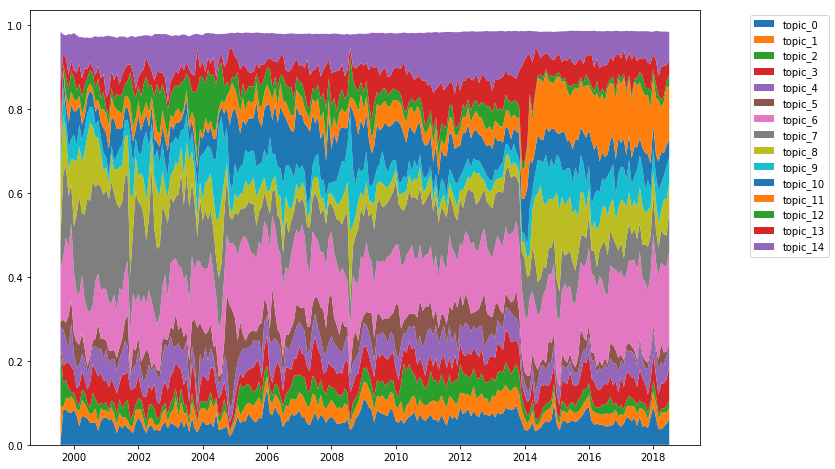

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [27]:
ldamodel1.print_topics()

[(0,
  '0.023*"тысяча" + 0.018*"миллион" + 0.017*"доллар" + 0.010*"миллиард" + 0.010*"гривна" + 0.010*"около" + 0.009*"рубль" + 0.008*"поставка" + 0.008*"предприятие" + 0.008*"средство"'),
 (1,
  '0.034*"язык" + 0.019*"латвия" + 0.017*"русский" + 0.017*"литва" + 0.014*"эстония" + 0.012*"армения" + 0.010*"2013" + 0.010*"образование" + 0.009*"школа" + 0.009*"facebook"'),
 (2,
  '0.028*"казахстан" + 0.023*"киргизия" + 0.017*"республика" + 0.016*"таджикистан" + 0.014*"узбекистан" + 0.010*"назарбаев" + 0.009*"уголь" + 0.007*"область" + 0.006*"глава" + 0.006*"киргизский"'),
 (3,
  '0.008*"самолёт" + 0.007*"из-за" + 0.006*"мост" + 0.006*"область" + 0.006*"2015" + 0.006*"территория" + 0.005*"корабль" + 0.005*"ракета" + 0.005*"пожар" + 0.004*"место"'),
 (4,
  '0.022*"российский" + 0.019*"белоруссия" + 0.013*"россия" + 0.011*"минск" + 0.011*"журналист" + 0.010*"белорусский" + 0.010*"александр" + 0.009*"лукашенко" + 0.009*"гражданин" + 0.008*"телеканал"'),
 (5,
  '0.044*"выбор" + 0.042*"партия" +

### Топ слова.

In [28]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [29]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [30]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

украина - 87127 times.
украинский - 38522 times.
россия - 37916 times.
республика - 31972 times.
власть - 30403 times.
российский - 27911 times.
глава - 27702 times.
грузия - 26582 times.
киев - 22094 times.
партия - 22047 times.
депутат - 20830 times.
информация - 20318 times.
министр - 18965 times.
военный - 18754 times.
область - 18726 times.
задержать - 18039 times.
территория - 17980 times.
решение - 17880 times.
сторона - 17265 times.
тысяча - 16848 times.
данные - 16594 times.
правительство - 16551 times.
принять - 16413 times.
парламент - 16281 times.
день - 16247 times.
лидер - 16164 times.
бывший - 15940 times.
сотрудник - 15788 times.
около - 15265 times.
выбор - 15151 times.
грузинский - 14630 times.
агентство - 14589 times.
новость - 14343 times.
верховный - 14162 times.
государство - 13966 times.
произойти - 13932 times.
вопрос - 13807 times.
против - 12669 times.
сила - 12561 times.
регион - 12402 times.
милиция - 12393 times.
государственный - 12369 times.
гражданин - 1